In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bgspy.genome import Genome
from bgspy.utils import load_bed_annotation, read_bed3, ranges_to_masks
from bgspy.genome import process_annotation

## Functions

In [5]:
def annot_summary(annot, seqlens):
    """
    Summarize annotation by chromosome.
    
    Returns (by chromosome) number of features, total bp of 
    features, and fraction of chromosome.    
    """
    annot, all_features = annot
    nfeats = defaultdict(Counter)
    total_bp = defaultdict(Counter)
    frac = defaultdict(Counter)
    lengths = defaultdict(lambda: defaultdict(list))
    for chrom, (ranges, features) in annot.items():
        for (start, end), feature in zip(ranges, features):
            nfeats[chrom][feature] += 1
            total_bp[chrom][feature] += end-start
            lengths[chrom][feature].append(end-start)
    for chrom in total_bp:
        for feature, val in total_bp[chrom].items():
            assert val < seqlens[chrom]
            frac[chrom][feature] = val / seqlens[chrom]
    return nfeats, total_bp, frac, lengths

def annot_merged_summary(annot, genome_length):
    """
    Summarize genome-wide annotation.
    
    Returns number of features, total bp of features, and fraction of genome.
    """
    annot, all_features = annot
    nfeats = Counter()
    total_bp = Counter()
    frac = Counter()
    lengths = defaultdict(list)
    for chrom, (ranges, features) in annot.items():
        for (start, end), feature in zip(ranges, features):
            nfeats[feature] += 1
            total_bp[feature] += end-start
            lengths[feature].append(end-start)

    for feature, val in total_bp.items():
        frac[feature] = val / genome_length
    return nfeats, total_bp, frac, lengths

In [6]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv")

In [7]:
hg38_autos = {c: k for c, k in g.seqlens.items() if c not in ('chrX', 'chrY', 'chrM')}

In [8]:
hg38_len = sum(v for c, v in hg38_autos.items())
hg38_len/1e9

2.875001522

## Annotation Tracks

We need basic statistics on the conserved annotation tracks — their composition etc.

### Merged Track

In [19]:
merged_annot = load_bed_annotation('../data/annotation/merged_utrs_cds_introns_phastcons.bed.gz')

In [20]:
merged_summary = annot_merged_summary(merged_annot, hg38_len)

In [21]:
# number of features
merged_summary[0]

Counter({'phastcons': 3672949, 'utr': 86319, 'intron': 239357, 'cds': 212056})

In [22]:
# proportion of total genome
merged_summary[2]

Counter({'phastcons': 0.022488878181539967,
         'utr': 0.017523136114708463,
         'intron': 0.41097623669362354,
         'cds': 0.012388024746235248})

This are roughly the proportions we expect: CDS ~2%, and introns are ~40%.

In [23]:
merged_summary_chrom = annot_summary(merged_annot, g.seqlens)

In [24]:
# inspect one chromosome
merged_summary_chrom[2]['chr1']

Counter({'phastcons': 0.021450585436193326,
         'utr': 0.02051145722201936,
         'intron': 0.41069157476885654,
         'cds': 0.0144966093704544})

Now let's load in in the segments into the `Segments` object that will be used to calculate B and make sure that these results match up with the raw annotation files (in the future this could be a unit test).

In [25]:
g.load_annot('../data/annotation/merged_utrs_cds_introns_phastcons.bed.gz')
g.load_recmap('../data/annotation/hapmap_genetic_map.txt')
g.create_segments()

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr1.
completed segmenting chr2.
completed segmenting chr3.
completed segmenting chr4.
completed segmenting chr5.
completed segmenting chr6.
completed segmenting chr7.
completed segmenting chr8.
completed segmenting chr9.
completed segmenting chr10.
completed segmenting chr11.
completed segmenting chr12.
completed segmenting chr13.
completed segmenting chr14.
completed segmenting chr15.
completed segmenting chr16.
completed segmenting chr17.
completed segmenting chr18.
completed segmenting chr19.
completed segmenting chr20.
completed segmenting chr21.
completed segmenting chr22.
completed segmenting chrX.
looking up map positions...	done.


In [26]:
stats = g.feature_stats(exclude_chroms=['X'])
stats

(Counter({'phastcons': 3744576,
          'utr': 143634,
          'intron': 1621052,
          'cds': 246814}),
 Counter({'phastcons': 64655559,
          'utr': 50379043,
          'intron': 1181557306,
          'cds': 35615590}),
 {'cds': 0.011750277660334043,
  'intron': 0.3898187961254123,
  'phastcons': 0.02133112972532842,
  'utr': 0.01662102869872177})

In [27]:
# now, let's compare these segment statistics from those from the merged annotation file directly
stats_chrom = g.feature_stats(by_chrom=True, exclude_chroms=['X'])

stats_chrom[2]['chr1'] == merged_summary_chrom[2]['chr1']

True

### Simulation Track (for Chromosome 10)



Random checking:

```
$ bioawk -cbed 'BEGIN{a=0} {a += $end-$start } END{print a}'    \
     ../../data/annotation/conserved_phastcons_thresh0_chr10.bed
7083369
```

In [28]:
sim_annot = load_bed_annotation('../data/annotation/conserved_phastcons_thresh0_chr10.bed')

In [38]:
np.diff(np.array(sim_annot.ranges['chr10'][0]), axis=1).sum()

7083369

In [29]:
sim_summary = annot_merged_summary(sim_annot, hg38_len)

In [39]:
# number of features
sim_summary[1]

Counter({'undefined': 7083369})

In [46]:
# what fraction of the chromosome?
annot_summary(sim_annot, g.seqlens)[2]['chr10']

Counter({'undefined': 0.05294099762251025})

## PhastCons Thresholding

In Murphy et al. they pay attention to thresholding their conserved tracks, so here's a little exploration into this with the phastCons dataset:

In [ ]:
d = pd.read_csv('../data/annotation/phastConsElements100way.txt.gz', sep='\t', names=('chr', 'start', 'end', 'lod', 'score'))
d = d.loc[d.chr.isin(hg38_autos)]
d['score'] = d['score'] / 1000
d['width'] = d['end'] - d['start']

In [ ]:
d['chr'].unique()

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9'],
      dtype=object)

In [ ]:
score = d['score'].values

(array([2.512443e+06, 3.886167e+06, 1.561838e+06, 8.749850e+05,
        3.985250e+05, 1.341740e+05, 3.636900e+04, 9.232000e+03,
        1.727000e+03, 6.400000e+01]),
 array([0.186 , 0.2674, 0.3488, 0.4302, 0.5116, 0.593 , 0.6744, 0.7558,
        0.8372, 0.9186, 1.    ]),
 <BarContainer object of 10 artists>)

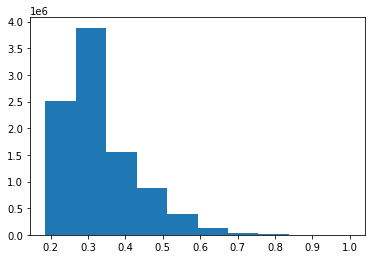

In [ ]:
plt.hist(score)

In [ ]:
q = np.quantile(score, 0.90)
q * 1000

471.0

In [ ]:
np.quantile(score, 0.95) * 1000

527.0

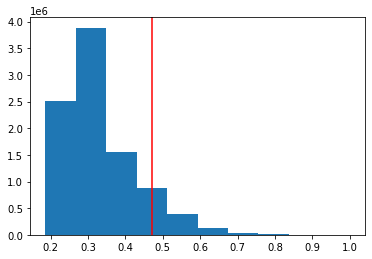

In [ ]:
plt.hist(score)
plt.axvline(q, c='r')

In [ ]:
q

0.471

In [71]:
d.loc[d.score > q].width.sum() / hg38_len, d.width.sum() / hg38_len

(0.01853522601369948, 0.050822503529791174)

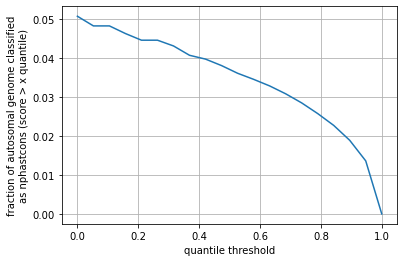

In [79]:
quants = np.linspace(0, 1, 20)

plt.plot(quants, [d.loc[d.score > np.quantile(d.score, q)].width.sum()/hg38_len for q in quants])
plt.ylabel('fraction of autosomal genome classified\nas nphastcons (score > x quantile)')
plt.xlabel('quantile threshold')
plt.grid()

In [81]:
np.quantile(score, (0, 0.5, 0.9, 0.95))*1000


array([186., 300., 471., 527.])